In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline
plt.style.use('seaborn-white')

## Cross-Validation

We discussed the distinction between the test error rate and the training error rate. The test error is the average error that results from using a statistical learning method to predict the response on a new observation—that is, a measurement that was not used in training the method. Given a data set, the use of a particular statistical learning method is warranted if it results in a low test error. The test error can be easily calculated if a designated test set is available. Unfortunately, this is usually not the case. In contrast, the training error can be easily calculated by applying the statistical learning method to the observations used in its training. But as we saw, the training error rate often is quite different from the test error rate, and in particular the former can dramatically underestimate the latter. In the absence of a very large designated test set that can be used to directly estimate the test error rate, a number of techniques can be used to estimate this quantity using the available training data. In this section, we instead consider a class of methods that estimate the test error rate by holding out a subset of the training observations from the fitting process, and then applying the statistical learning method to those held out observations.

### The Validation Set Approach
Suppose that we would like to estimate the test error associated with fitting a particular statistical learning method on a set of observations. The validation set approach is randomly dividing the available set of observations into two parts, a training set and a validation set or hold-out set. The model is fit on the training set, and the fitted model is used to predict in the validation set. The resulting validation provides an estimate of the test error rate.



Now we use the **Auto** dataset to illustrate the CV method

In [2]:
df1 = pd.read_csv('Auto.csv', na_values='?').dropna()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null int64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


There appears to be a non-linear relationship between **mpg** and horsepower, and the model that predicts **mpg** using **horsepower** and **horsepower**^2 gives better results than a model that uses only a linear term (try by yourself). It is natural to wonder whether a cubic or higher-order fit might provide even better results. We could answer this question using the validation method. We randomly split the 392 observations into two sets, a training set containing 196 of the data points, and a validation set containing the remaining 196 observations. The validation set error rates that result from fitting various regression models on the training sample and evaluating their performance on the validation sample, using MSE as a measure of validation set error.

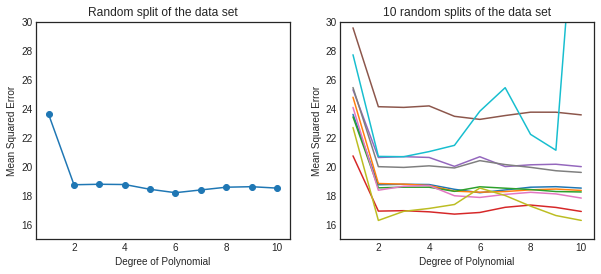

In [3]:
t_prop = 0.5
p_order = np.arange(1,11)
r_state = np.arange(0,10)

X, Y = np.meshgrid(p_order, r_state, indexing='ij')
Z = np.zeros((p_order.size,r_state.size))

regr = skl_lm.LinearRegression()

# Generate 10 random splits of the dataset
for (i,j),v in np.ndenumerate(Z):
    poly = PolynomialFeatures(int(X[i,j]))
    X_poly = poly.fit_transform(df1.horsepower.values.reshape(-1,1))
    
    X_train, X_test, y_train, y_test = train_test_split(X_poly, df1.mpg.ravel(),
                                                        test_size=t_prop, random_state=Y[i,j])
                                                                        
    regr.fit(X_train, y_train)
    pred = regr.predict(X_test)
    Z[i,j]= mean_squared_error(y_test, pred)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

# Left plot (first split)
ax1.plot(X.T[0],Z.T[0], '-o')
ax1.set_title('Random split of the data set')

# Right plot (all splits)
ax2.plot(X,Z)
ax2.set_title('10 random splits of the data set')

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5,10.5)
    ax.set_xticks(range(2,11,2));

Left: *Validation error estimates for a single split into training and validation data sets.*

Right: *The validation method was repeated ten times, each time using a different random split of the observations into a trainingset and a validation set. This illustrates the variability in the estimated test MSE that results from this approach.*

In the figure above, The validation set MSE for the quadratic fit is considerably smaller than for the linear fit. However, the validation set MSE for the cubic fit is actually slightly larger than for the quadratic fit. This implies that including a cubic term in the regression does not lead to better prediction than simply using a quadratic term. But it is worth noting that each of the ten curves results in a different test MSE estimate for each of the ten regression models considered. And there is no consensus among the curves as to which model results in the smallest validation set MSE. Based on the variability among these curves, all that we can conclude with any confidence is that the linear fit is not adequate for this data.

Hence, the drawbacks of this method are:
* the validation estimate of the test error rate can be highly variable, depending on precisely which observations are included in the training set and which observations are included in the validation set
+ In the validation approach, only a subset of the observations—those that are included in the training set rather than in the validation set—are used to fit the model (trained on fewer observation).

### Leave-One-Out Cross-Validation
Like the validation set approach, LOOCV involves splitting the set of observations into two parts. However, instead of creating two subsets of comparable size, a single observation $(x_1,y_1)$ is used for the validation set, and the remaining observations $\{(x_2 , y_2 ), . . . , (x_n,y_n)\}$ make up the training set.

The statistical learning method is fit on the n − 1 training observations, and a prediction $\hat{y}_1$ is made for the excluded observation, using its value $x_1$ . Since $(x_1,y_1)$ was not used in the fitting process, $MSE_1 = (y_1-\hat{y}_1)^2$. 

We can repeat the procedure by selecting other data points in the dataset to be validation set. The LOOCV estimate for the test MSE is the average of these n test error estimate:
$$MSE=\frac{1}{n}\sum MSE_i$$

LOOCV has a couple of major advantages over the validation set approach. First, it has far less bias. Second, in contrast to the validation approach which will yield different results when applied repeatedly due to randomness in the training/validation set splits, performing LOOCV multiple times will always yield the same results: there is no randomness in the training/vali-dation set splits. LOOCV has the potential to be expensive to implement, since the model
has to be fit n times. This can be very time consuming if n is large, and if each individual model is slow to fit,

### k-Fold Cross-Validation
An alternative to LOOCV is k-fold CV. This approach involves randomly dividing the set of observations into k groups, or folds, of approximately equal size. The first fold is treated as a validation set, and the method is fit on the remaining k − 1 folds. The k fold estimate for the test MSE is the average of these n test error estimate:
$$MSE=\frac{1}{k}\sum MSE_i$$

We now use this method for the **Auto** data

In [4]:
p_order = np.arange(1,11)
r_state = np.arange(0,10)

# LeaveOneOut CV
regr = skl_lm.LinearRegression()
loo = LeaveOneOut()
loo.get_n_splits(df1)
scores = list()

for i in p_order:
    poly = PolynomialFeatures(i)
    X_poly = poly.fit_transform(df1.horsepower.values.reshape(-1,1))
    score = cross_val_score(regr, X_poly, df1.mpg, cv=loo, scoring='neg_mean_squared_error').mean()
    scores.append(score)

In [5]:
# k-fold CV
folds = 10
elements = len(df1.index)

X, Y = np.meshgrid(p_order, r_state, indexing='ij')
Z = np.zeros((p_order.size,r_state.size))

regr = skl_lm.LinearRegression()

for (i,j),v in np.ndenumerate(Z):
    poly = PolynomialFeatures(X[i,j])
    X_poly = poly.fit_transform(df1.horsepower.values.reshape(-1,1))
    kf_10 = KFold(n_splits=folds, random_state=Y[i,j])
    Z[i,j] = cross_val_score(regr, X_poly, df1.mpg, cv=kf_10, scoring='neg_mean_squared_error').mean()

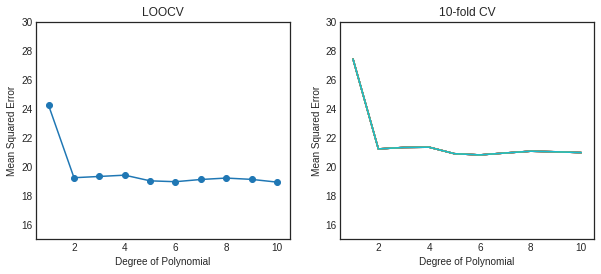

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

# Note: cross_val_score() method return negative values for the scores.
# https://github.com/scikit-learn/scikit-learn/issues/2439

# Left plot
ax1.plot(p_order, np.array(scores)*-1, '-o')
ax1.set_title('LOOCV')

# Right plot
ax2.plot(X,Z*-1)
ax2.set_title('10-fold CV')

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5,10.5)
    ax.set_xticks(range(2,11,2));


The Right figure has nine different 10-fold CV estimates for the Auto data set, each resulting from a different random
split of the observations into ten folds. As we can see from the figure, there is some variability in the CV estimates as a result of the variability in how the observations are divided into ten folds. But this variability is typically much lower than the variability in the test error estimates that results from the validation set approach.

Try to firgure CV method in classification problem. Will be on HW